In [24]:
import dxchange
import matplotlib.pyplot as plt
import adorym
import adorym.wrappers as w
import torch as tc
import torch.autograd as tag
import numpy as np

adorym.global_settings.backend = 'pytorch'

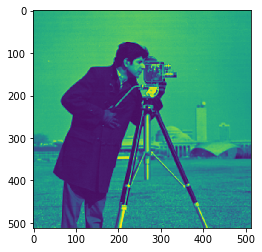

In [25]:
img_true = dxchange.read_tiff('raw/cameraman_512.tiff')
plt.imshow(img_true)

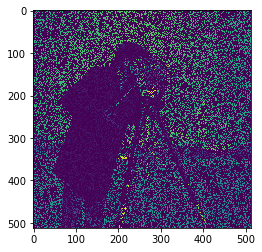

In [26]:
mask_cs = np.random.rand(*img_true.shape)
mask_cs = np.where(mask_cs < 0.3, 1, 0) # Set given fraction of pixels to 1, else to 0
mask_cs = mask_cs.astype('bool')
img_cs = mask_cs * img_true
plt.imshow(img_cs)

In [27]:
def total_variation(arr, axis_offset=0):
    """
    Calculate total variation of a 3D array.
    :param arr: 3D Tensor.
    :return: Scalar.
    """
    arr_size = 1
    for i in range(len(arr.shape)):
        arr_size = arr_size * arr.shape[i]
    res = w.sum(w.abs(w.roll(arr, 1, axes=0 + axis_offset) - arr))
    res = res + w.sum(w.abs(w.roll(arr, 1, axes=1 + axis_offset) - arr))
    res = res / arr_size
    return res

In [34]:
device = tc.device('cuda:0')
x = tc.tensor(img_cs, device=device, requires_grad=True)
y0 = tc.tensor(img_true[mask_cs], device=device, requires_grad=False)
opt = tc.optim.Adam([x], 1.)

In [35]:
for i_epoch in range(1000):
    opt.zero_grad()
    y = x[mask_cs]
    loss = w.mean((y - y0) ** 2) + 50. * total_variation(x)
    # grad = tag.grad(loss, x, retain_graph=True, create_graph=False, allow_unused=False)
    loss.backward()
    #x = x - 10 * grad[0]
    opt.step()
    if i_epoch % 100 == 0:
        print('{}: {}'.format(i_epoch, w.to_numpy(loss)))
img_res = w.to_numpy(x)

0: 5029.890625
100: 2374.736083984375
200: 856.8172607421875
300: 307.0096740722656
400: 228.69534301757812
500: 224.59097290039062
600: 223.6843719482422
700: 223.29287719726562
800: 223.09364318847656
900: 223.0227508544922


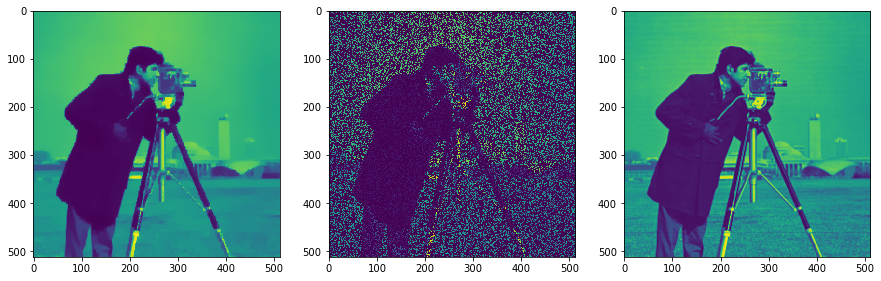

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_res)
axes[1].imshow(img_cs)
axes[2].imshow(img_true)